In [1]:
#DB
import os
import psycopg2

# Helpers
import numpy as np
import qgrid
from tqdm import tqdm_notebook
import time
import pandas as pd

# Evaluation
from gap import define_k

# Plots
import matplotlib.pyplot as plt

## Connect to DB

In [2]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "***REMOVED***",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [4]:
%%time

vectorizers = ['CountVectorizer',
               'TfidfVectorizer', 
               'NCutVectorizer'
              ]
min_df = np.arange(0.05, 0.5, 0.05)
binary = [
    True, 
    False
]
cluster_methods = ['nmf']#, 'lda']
#, 'hierarchical', 'gaussian_mixture', 'spectral_clustering']
metric = [
    'euclidean', 
    'cosine',
    'correlation'
         ]

total = 0
total_rows = 0

# Grid search
for v in tqdm_notebook(vectorizers, desc="vectorizer", leave=False):
    for m in tqdm_notebook(min_df, desc="min_df", leave=False):
        for b in tqdm_notebook(binary, desc="binary", leave=False):
            for dist in tqdm_notebook(metric, desc="metric", leave=False):
                for method in tqdm_notebook(cluster_methods, desc="method", leave=False):
#                         total += 1
                    # Get results for each combination and get best k value
                    cols = ["experiment_id", "dataset", "k", "gap", "gap_std", "silhouette", "silhouette_samples", 
                            "coherence_samples", "coherence_med", "coherence_std", "coherence_k"]
#                         cols = ['dataset', 'k', 'min_df', 'is_binary', 'vectorizer', 'method', 'distance', 'gap', 'clustering_time', 'gap_time', 'silhouette_time', 'coherence_time']

                    query = "SELECT %s from experiments where " % ", ".join(cols)
                    where_clause = [("vectorizer", v), ("min_df", m), ("is_binary", b), 
                                    ("distance", dist), ("method", method), ("dataset", 'solution_cleaned')]
                    query += " AND ".join(["%s = '%s'" % item for item in where_clause])
#                         print(query)
                    cursor.execute(query)
                    r = cursor.fetchall()
                    df = pd.DataFrame(r, columns=cols)
                    total += df.shape[0]
                    total_rows += 1

                    if df.shape[0]:
                        experiment_id = df['experiment_id'].values.tolist()[0]

                        # Get measure values
                        gaps_original = df['gap'].values.tolist()
                        gaps = gaps_original[:]
                        error = df['gap_std'].values.tolist()
                        sils = df['silhouette'].values.tolist()
                        coherence = df['coherence_med'].values.tolist()
                        coherence_std = df['coherence_std'].values.tolist()
                        coherence_array = df['coherence_samples'].values.tolist()

                        # Gap
                        gap_k, gap_k2 = define_k(gaps, error)
                        # Silhouette
                        silhouette_k = np.argsort(np.asarray(sils))[::-1][0]+2
                        silhouette_k2 = np.argsort(np.asarray(sils))[::-1][1]+2
                        # Coherence
                        coherence_med = []
#                         coherence_std = []
                        for c in coherence_array:
                            coherence_med.append(np.median(np.asarray([i for i in c if str(i) != 'nan'])))
#                             coherence_std.append(np.std(np.asarray([i for i in c if str(i) != 'nan'])))
                        coherence_k = np.argsort(np.asarray(coherence_med))[::-1][0]+2
                        coherence_k2 = np.argsort(np.asarray(coherence_med))[::-1][1]+2

                        cols = ["experiment_id", "gap_k", "gap_k2", "silhouette_k", "silhouette_k2", "coherence_k", "coherence_k2"]
                        insert_query = "INSERT INTO EXPERIMENTS_RESULT (%s) VALUES " % ", ".join(cols)
                        values = [experiment_id, gap_k, gap_k2, silhouette_k, silhouette_k2, coherence_k, coherence_k2]
                        values = [int(i) for i in values]
                        insert_query += "(" + ", ".join(["%s"]*len(values)) + ")"
                        query = cursor.mogrify(insert_query, values)
                        try:
                            cursor.execute(query)
                        except psycopg2.IntegrityError:
                            print("error on exp id %d" % experiment_id)
                            pass
#                         break
#                     break
#                 break
#             break
#         break
#     break

/home/lmoraes/machine-teaching/machineteaching/gap.py:97: RuntimeWarning: invalid value encountered in greater
  gap_diff = np.array(gaps) > diff


CPU times: user 5.33 s, sys: 184 ms, total: 5.52 s
Wall time: 50.9 s


In [6]:
total_rows

162

In [7]:
df.sort_values('k')

,experiment_id,dataset,k,gap,gap_std,silhouette,silhouette_samples,coherence_samples,coherence_med,coherence_std,coherence_k
0,3343,solution_cleaned,2,-0.379455,0.042938,0.231953,"[0.363933, -0.121124, 0.393696, 0.229898, 0.33...","[-0.367618, -0.320221]",-0.343919,0.023699,2
1,3346,solution_cleaned,3,-0.416307,0.050053,0.159546,"[0.172255, -0.137655, 0.17968, 0.192183, 0.244...","[-0.42455, -0.285958, -0.793357]",-0.424550,0.214134,3
2,3349,solution_cleaned,4,-0.325083,0.057242,0.165351,"[0.176855, 0.121285, -0.194166, 0.135314, 0.17...","[-0.450998, -0.239854, -0.546252, -0.219151]",-0.345426,0.138905,4


In [20]:
# Get experiment conditions
exp_id = 2877
# exp_id = 1618
# exp_id = 1616
# exp_id = 558
cols = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset"]
query = "SELECT %s from experiments where experiment_id = %s" % (", ".join(cols), exp_id) 
cursor.execute(query)
r = cursor.fetchall()
# print(r[0])
where_clause = zip(*[cols, r[0]])

# Get all k
cols = ["experiment_id", "dataset", "k", "gap", "gap_std", "silhouette", "silhouette_samples", 
        "coherence_samples", "coherence_med", "coherence_std", "coherence_k", "model"]

query = "SELECT %s from experiments where " % ", ".join(cols)
query += " AND ".join(["%s = '%s'" % item for item in where_clause])
cursor.execute(query)
print(query)
r = cursor.fetchall()
df = pd.DataFrame(r, columns=cols)

gaps_original = df['gap'].values.tolist()
gaps = gaps_original[:]
error = df['gap_std'].values.tolist()
sils = df['silhouette'].values.tolist()
coherence = df['coherence_med'].values.tolist()
coherence_std = df['coherence_std'].values.tolist()
coherence_array = df['coherence_samples'].values.tolist()

# Get measure values
gaps_original = df['gap'].values.tolist()
gaps = gaps_original[:]
error = df['gap_std'].values.tolist()
sils = df['silhouette'].values.tolist()
coherence = df['coherence_med'].values.tolist()
coherence_std = df['coherence_std'].values.tolist()
coherence_array = df['coherence_samples'].values.tolist()
# print(coherence)
# print(coherence_array)

# Gap
gap_k, gap_k2 = define_k(gaps, error)
# Silhouette
silhouette_k = np.argsort(np.asarray(sils))[::-1][0]+2
silhouette_k2 = np.argsort(np.asarray(sils))[::-1][1]+2
# Coherence
coherence_med = []
#                         coherence_std = []
for c in coherence_array:
    coherence_med.append(np.median(np.asarray([i for i in c if str(i) != 'nan'])))
#                             coherence_std.append(np.std(np.asarray([i for i in c if str(i) != 'nan'])))
coherence_k = np.argsort(np.asarray(coherence_med))[::-1][0]+2
coherence_k2 = np.argsort(np.asarray(coherence_med))[::-1][1]+2

SELECT experiment_id, dataset, k, gap, gap_std, silhouette, silhouette_samples, coherence_samples, coherence_med, coherence_std, coherence_k, model from experiments where vectorizer = 'TfidfVectorizer' AND min_df = '0.05' AND is_binary = 'False' AND distance = 'cosine' AND method = 'nmf' AND dataset = 'solution_cleaned'


In [21]:
df

,experiment_id,dataset,k,gap,gap_std,silhouette,silhouette_samples,coherence_samples,coherence_med,coherence_std,coherence_k,model
0,2877,solution_cleaned,2,-1.101690,0.016318,0.113856,"[0.0910362, 0.0899089, 0.0650297, 0.347683, 0....","[0.169276, -0.018794]",0.075241,0.094035,2,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
1,2880,solution_cleaned,3,-1.083370,0.015344,0.110495,"[0.0427183, 0.0797941, 0.0583066, 0.348751, 0....","[0.247658, 0.00702558, nan]",NaN,NaN,3,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
2,2883,solution_cleaned,4,-1.051180,0.016759,0.131671,"[0.0209995, 0.0175666, 0.0851467, 0.381323, 0....","[0.364865, 0.0185718, nan, nan]",NaN,NaN,4,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
3,2886,solution_cleaned,5,-1.032390,0.014738,0.128372,"[-0.0299044, 0.0595839, 0.0839842, 0.376996, 0...","[-0.0878919, -0.129132, nan, nan, 0.582378]",NaN,NaN,5,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
4,2889,solution_cleaned,6,-1.005820,0.017520,0.131839,"[0.125599, -0.0499577, 0.208344, 0.362252, 0.2...","[-0.831837, nan, nan, nan, -0.763933, -1.83684]",NaN,NaN,6,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
5,2892,solution_cleaned,7,-0.977292,0.016899,0.171261,"[0.066834, 0.0404079, -0.0614916, 0.42232, 0.3...","[-0.0661229, -0.787303, -1.4218, nan, -1.67933...",NaN,NaN,7,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."


In [22]:
%matplotlib notebook

<IPython.core.display.Javascript object>


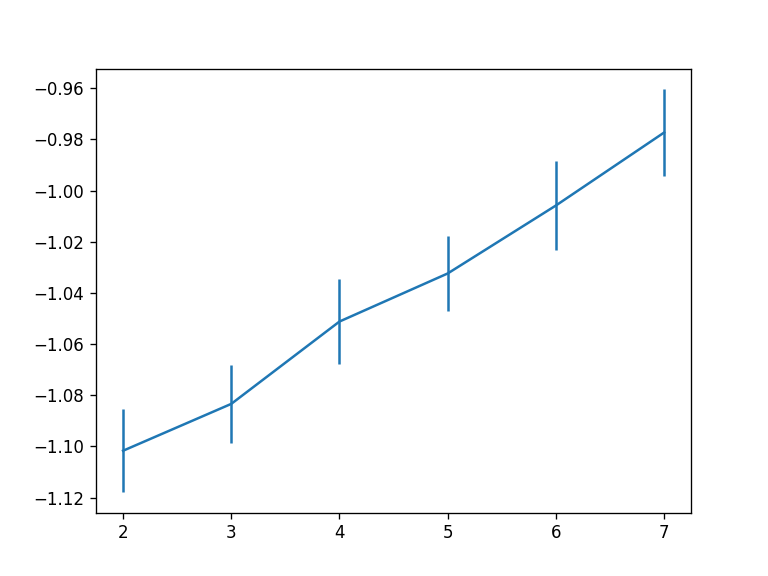

k = 2
2nd k = 2


In [23]:
# Plot data
plt.figure()
plt.errorbar(range(2,len(gaps)+2), gaps_original, yerr=error)
plt.show()

# Get best k
print("k = %d" % gap_k)
print("2nd k = %d" % gap_k2)

<IPython.core.display.Javascript object>


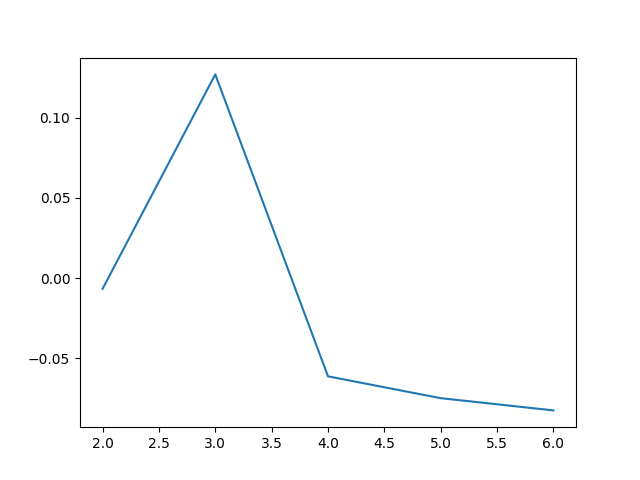

k = 3
2nd k = 2


In [81]:
# Plot data
plt.figure()
plt.plot(range(2,len(sils)+2), sils)
plt.show()

# Get best k
print("k = %d" % silhouette_k)
print("2nd k = %d" % silhouette_k2)

<IPython.core.display.Javascript object>


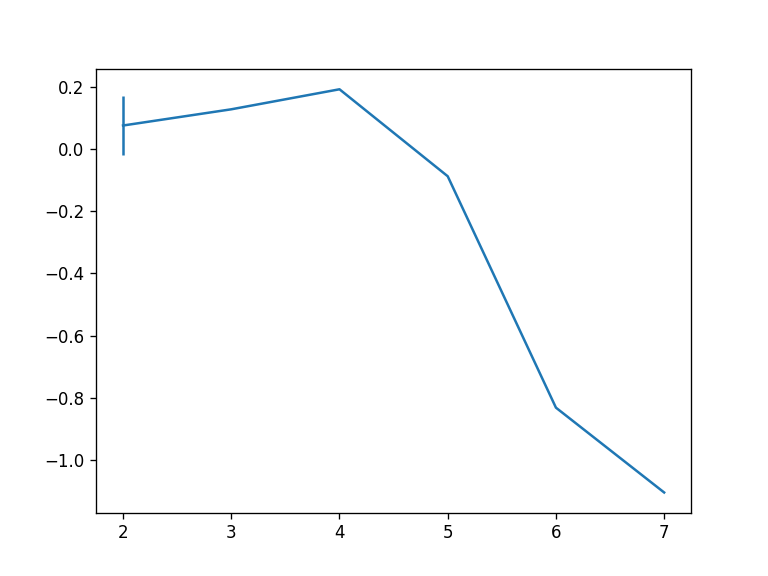

k = 4
2nd k = 3
CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 16.2 ms


In [24]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence)+2), coherence_med, yerr=coherence_std)
plt.show()

# Get best k
# Get best k
print("k = %d" % coherence_k)
print("2nd k = %d" % coherence_k2)

<IPython.core.display.Javascript object>


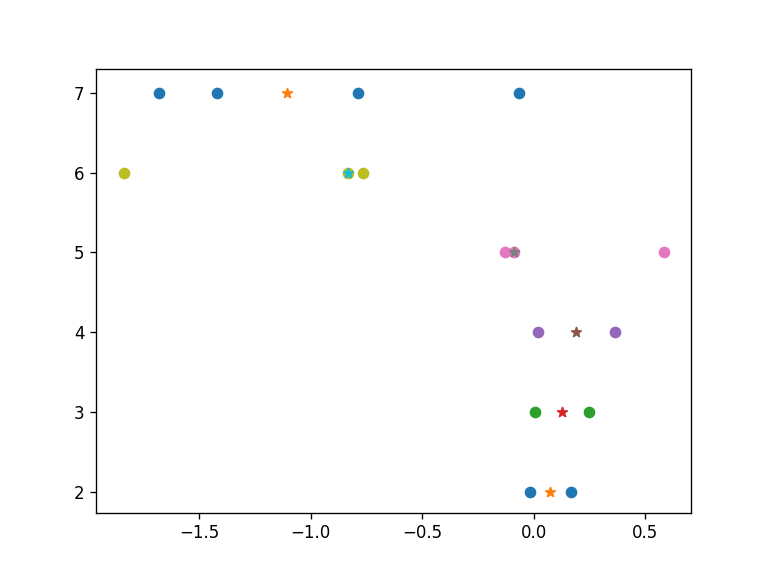

In [25]:
plt.figure()
for idx, i in enumerate(coherence_array):
    median = np.median([item for item in i if str(item) != 'nan'])
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")

In [208]:
import pickle
import base64
from clustering import Clustering

In [242]:
query = "select model, X from experiments where experiment_id = 1623"
cursor.execute(query)
r = cursor.fetchall()

In [243]:
model_db = pickle.loads(base64.b64decode(r[0][0]))
model_db

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=4036125560, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [248]:
X = np.asarray(r[0][1])
X.shape

(2224, 64)

In [201]:
def get_docs(topics):
    docs = []
    base_path = "bbc"
    for t in topics:
        docs_title = os.listdir("%s/%s" % (base_path,t))
        for item in docs_title:
            with open('%s/%s/%s' %(base_path, t, item), 'r') as txtfile:
                try:
                    docs.append(txtfile.read())
                except UnicodeDecodeError:
                    print("Error on doc %s/%s" % (t,item))
    return docs

In [215]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = 'word',
                                          binary=binary,
                                          min_df=min_df,
                                         )

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T
    
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()


In [217]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
#     vectorizer = vectorizer_method(analyzer = python_analyzer,
    vectorizer = vectorizer_method(analyzer = 'word',
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features, vectorizer.get_feature_names()

In [249]:
topic_list = ["business", "entertainment", "politics", "sport", "tech"]
docs = get_docs(topic_list)
v = NCutVectorizer
b = True
m = 0.35
k = 8
dist = 'correlation'

train_data_features, feature_names = create_bag_of_words(docs, v, binary=b, min_df=m)
clustering = Clustering(train_data_features, k, metric=dist)

Error on doc sport/199.txt


In [250]:
model, document_topic, word_topic = getattr(clustering, method)()

In [251]:
word_topic.shape

(8, 64)

In [241]:
model_db.components_.shape

(8, 64)

In [279]:
def print_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        names = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(names)
        message += ", ".join(names)
        print(message)
    print()
    return top_words

In [280]:
print("\nTopics in NMF model (Frobenius norm):")
# print(len(feature_names))
top_words = print_top_words(model, feature_names, 10)


Topics in NMF model (Frobenius norm):
Topic #0: his, who, after, he, was, the, in, to, of, and
Topic #1: people, or, other, more, their, than, one, who, they, are
Topic #2: its, us, has, the, also, and, of, in, to, said
Topic #3: first, time, there, new, when, us, out, but, all, about
Topic #4: two, over, were, one, after, their, when, had, up, they
Topic #5: if, we, can, could, there, all, not, would, out, they
Topic #6: last, year, up, in, the, to, new, of, will, and
Topic #7: mr, would, were, had, could, he, not, over, which, an



In [262]:
df = pd.DataFrame(word_topic)

In [315]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=1)
    matrix_norm = matrix / row_sums[:, np.newaxis]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

In [355]:
# word_topic_norm = normalize_per_row(word_topic)
x = ["Topic %d" % (idx+1) for idx in range(model.components_.shape[0])]
y = feature_names
# word_topic_df = pd.DataFrame(word_topic_norm.T, index=y, columns=x)
word_topic_df = pd.DataFrame(word_topic.T, index=y, columns=x)
word_topic_df = sort_distribution(word_topic_df, x, MIN_PROB=0.3)

<IPython.core.display.Javascript object>


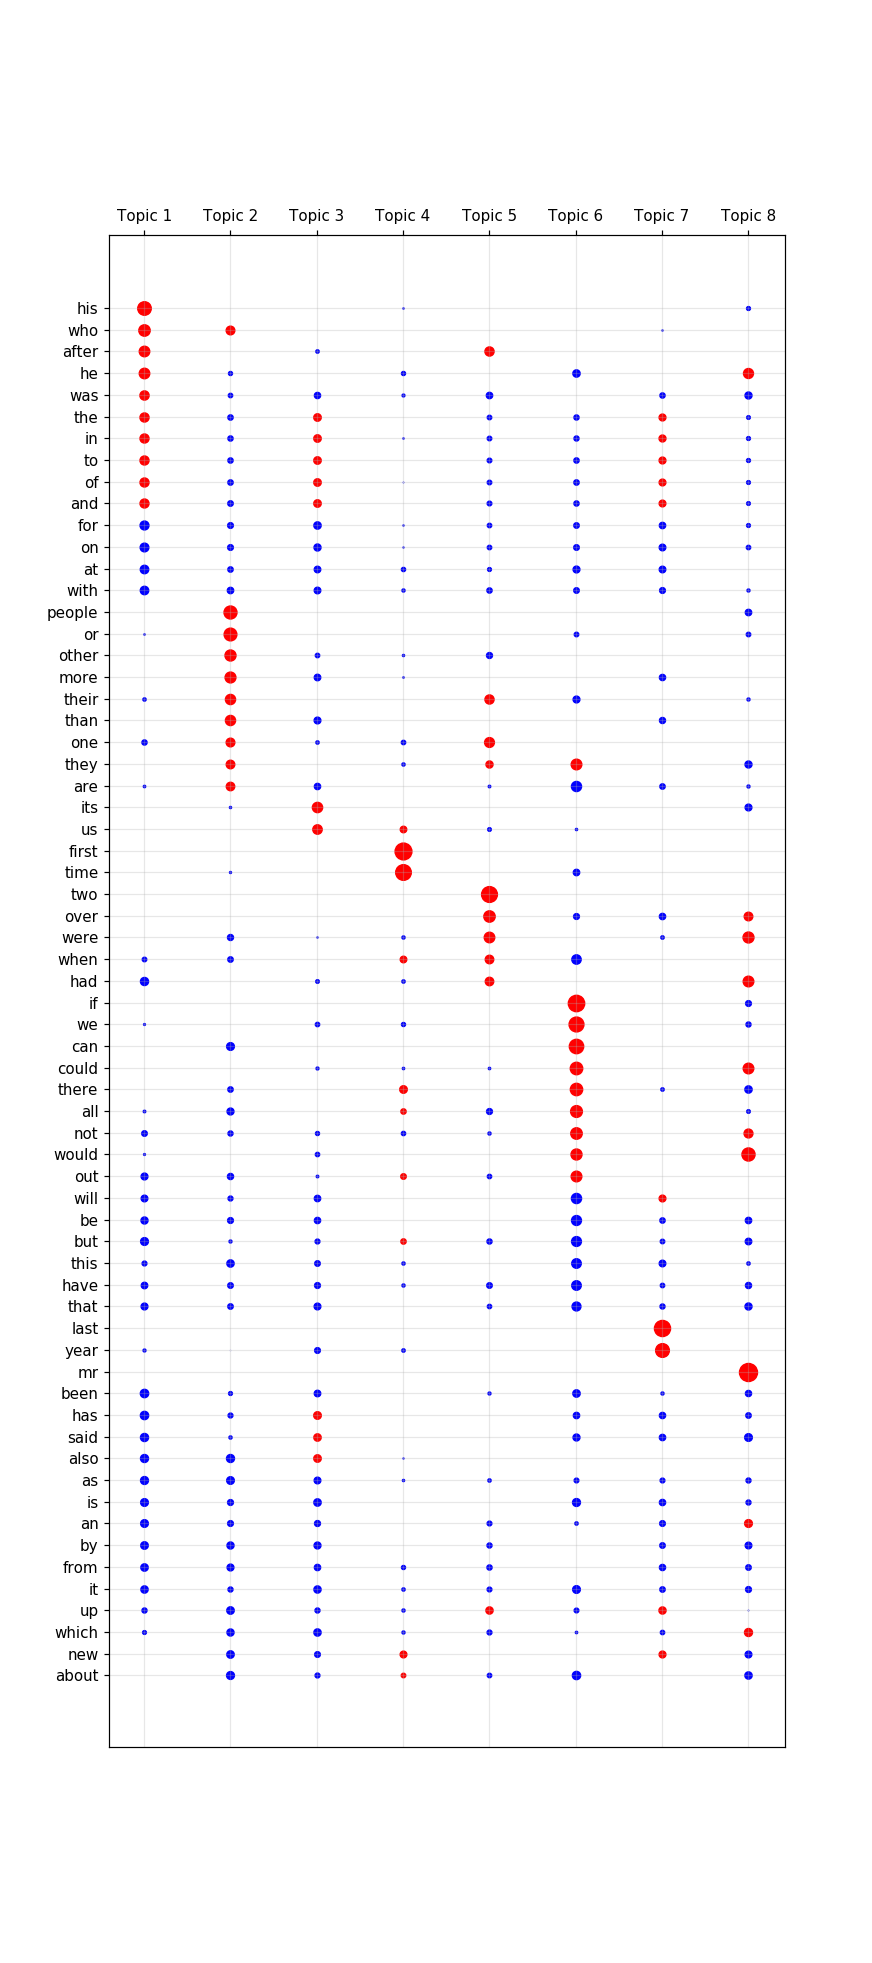

In [358]:
plt.figure(figsize=(8,18))

points = word_topic_df.values
cols = word_topic_df.columns
rows = word_topic_df.index

plt.xticks(range(0,len(cols)), cols)
plt.yticks(range(0,len(rows)), rows)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=False,
    labeltop=True)
plt.grid(alpha=0.3)

for x_item in range(len(cols)):
    for y_item in range(len(rows)):

        if rows[y_item] in top_words[x_item]:
            c = 'r'
        else:
            c = 'b'
        plt.scatter(x_item, y_item, s=points[y_item, x_item]*100, c=c)

plt.gca().invert_yaxis()
plt.show()